In [1]:
import sys,re
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
sys.path.insert(0, '../../../../beyourself/beyourself')
from beyourself.core.util import maybe_create_folder
from beyourself.core.util import human_to_epoch
import os
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from IPython.display import display, HTML
from sklearn import preprocessing
from beyourself.evaluation.ml import metrics_evaluate
from datetime import timedelta, date
import pandas as pd
import datetime
import pickle
import settings
from matplotlib import pyplot as plt
from matplotlib import interactive
import pytz
interactive(True)

TIMEZONE = pytz.timezone("America/Chicago")





def df_to_datetime_tz_aware(in_df, column_list):
    from datetime import datetime, timedelta, date
    from six import string_types
    import numpy as np

    df = in_df.copy()

    for column in column_list:
        if len(df): # if empty df, continue
            d = df[column].iloc[0]
            # print(type(d))
            # if type is string 
            if isinstance(d, string_types):#if "import datetime" then "isinstance(x, datetime.date)"
                if check_end_with_timezone(d):
                    # if datetime string end with time zone
                    # print('Column '+column+' time zone contained')
                    df[column] = pd.to_datetime(df[column],utc=True).apply(lambda x: x.tz_convert(settings.TIMEZONE))
                else:
                    # if no time zone contained
                    # print('Column '+column+' no time zone contained')
                    df[column] = pd.to_datetime(df[column]).apply(lambda x: x.tz_localize(settings.TIMEZONE))
            
            # if type is datetime.date
            elif isinstance(d, date):

                if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
                    # if datetime is tz naive
                    print('Column '+column+" time zone naive")
                    df[column] = df[column].apply(lambda x: x.replace(tzinfo=pytz.UTC).astimezone(settings.TIMEZONE))

                else:
                    print(d.tzinfo)
                    # if datetime is tz aware
                    # print('Column '+column+" time zone aware")
            # if type is unixtime (13-digit int):
            
            elif isinstance(d, (int, np.int64)):                
                df[column] = pd.to_datetime(df[column], unit='ms', utc=True)\
                            .dt.tz_convert(settings["TIMEZONE"])
            
            else:
                print('Cannot recognize the data type.')
        else:
            print('Empty column')

    return df



def check_end_with_timezone(s):# TODO: limit re to -2numbers:2number
    m = re.search(r'-\d+:\d+$', s)
    return True if m else False

def lprint(logfile, *argv): # for python version 3

    """ 
    Function description: 
    ----------
        Save output to log files and print on the screen.

    Function description: 
    ----------
        var = 1
        lprint('log.txt', var)
        lprint('log.txt','Python',' code')

    Parameters
    ----------
        logfile:                 the log file path and file name.
        argv:                    what should 
        
    Return
    ------
        none

    Author
    ------
    Shibo(shibozhang2015@u.northwestern.edu)
    """

    # argument check
    if len(argv) == 0:
        print('Err: wrong usage of func lprint().')
        sys.exit()

    argAll = argv[0] if isinstance(argv[0], str) else str(argv[0])
    for arg in argv[1:]:
        argAll = argAll + (arg if isinstance(arg, str) else str(arg))
    
    print(argAll)

    with open(logfile, 'a') as out:
        out.write(argAll + '\n')


def worn_on_points(in_df):
    df = in_df.copy()

    # df['time'] = df.index

    df = df[['proximity', 'ambient', 'leanForward', 'energy']]
    # df['time'] = df['time'].astype(np.int64) // 10**6

    # print(len(df))

    # df_dev = pd.rolling_std(df,6000)#5 min
    df_dev = df.rolling(6000).std()#5 min
    # df_mean = pd.rolling_mean(df,6000)#5 min
    df_mean = df.rolling(6000).mean()#5 min

    df_dev.columns = ['proximity_dev', 'ambient_dev',
     'leanForward_dev',
     'energy_dev']
    df_mean.columns = ['proximity_mean', 'ambient_mean',
     'leanForward_mean',
     'energy_mean']

    df_md = pd.concat([df_mean, df_dev], axis=1)

    len_na = df_md['proximity_mean'].isnull().sum()
    df_md_m = df_md[df_md['ambient_mean']>5]
    df_md_m = df_md_m[df_md_m['leanForward_dev']>0.1]

    necklaceoff_timemean = df_md[(df_md['ambient_mean']<5)|\
                                (df_md_m['leanForward_dev']<0.1)]

    if len(necklaceoff_timemean):
        print(necklaceoff_timemean[['proximity_mean','leanForward_mean']])

    len_worn = len(df_md_m)+len_na

    return len_worn




203
Day: 2
27685
71191


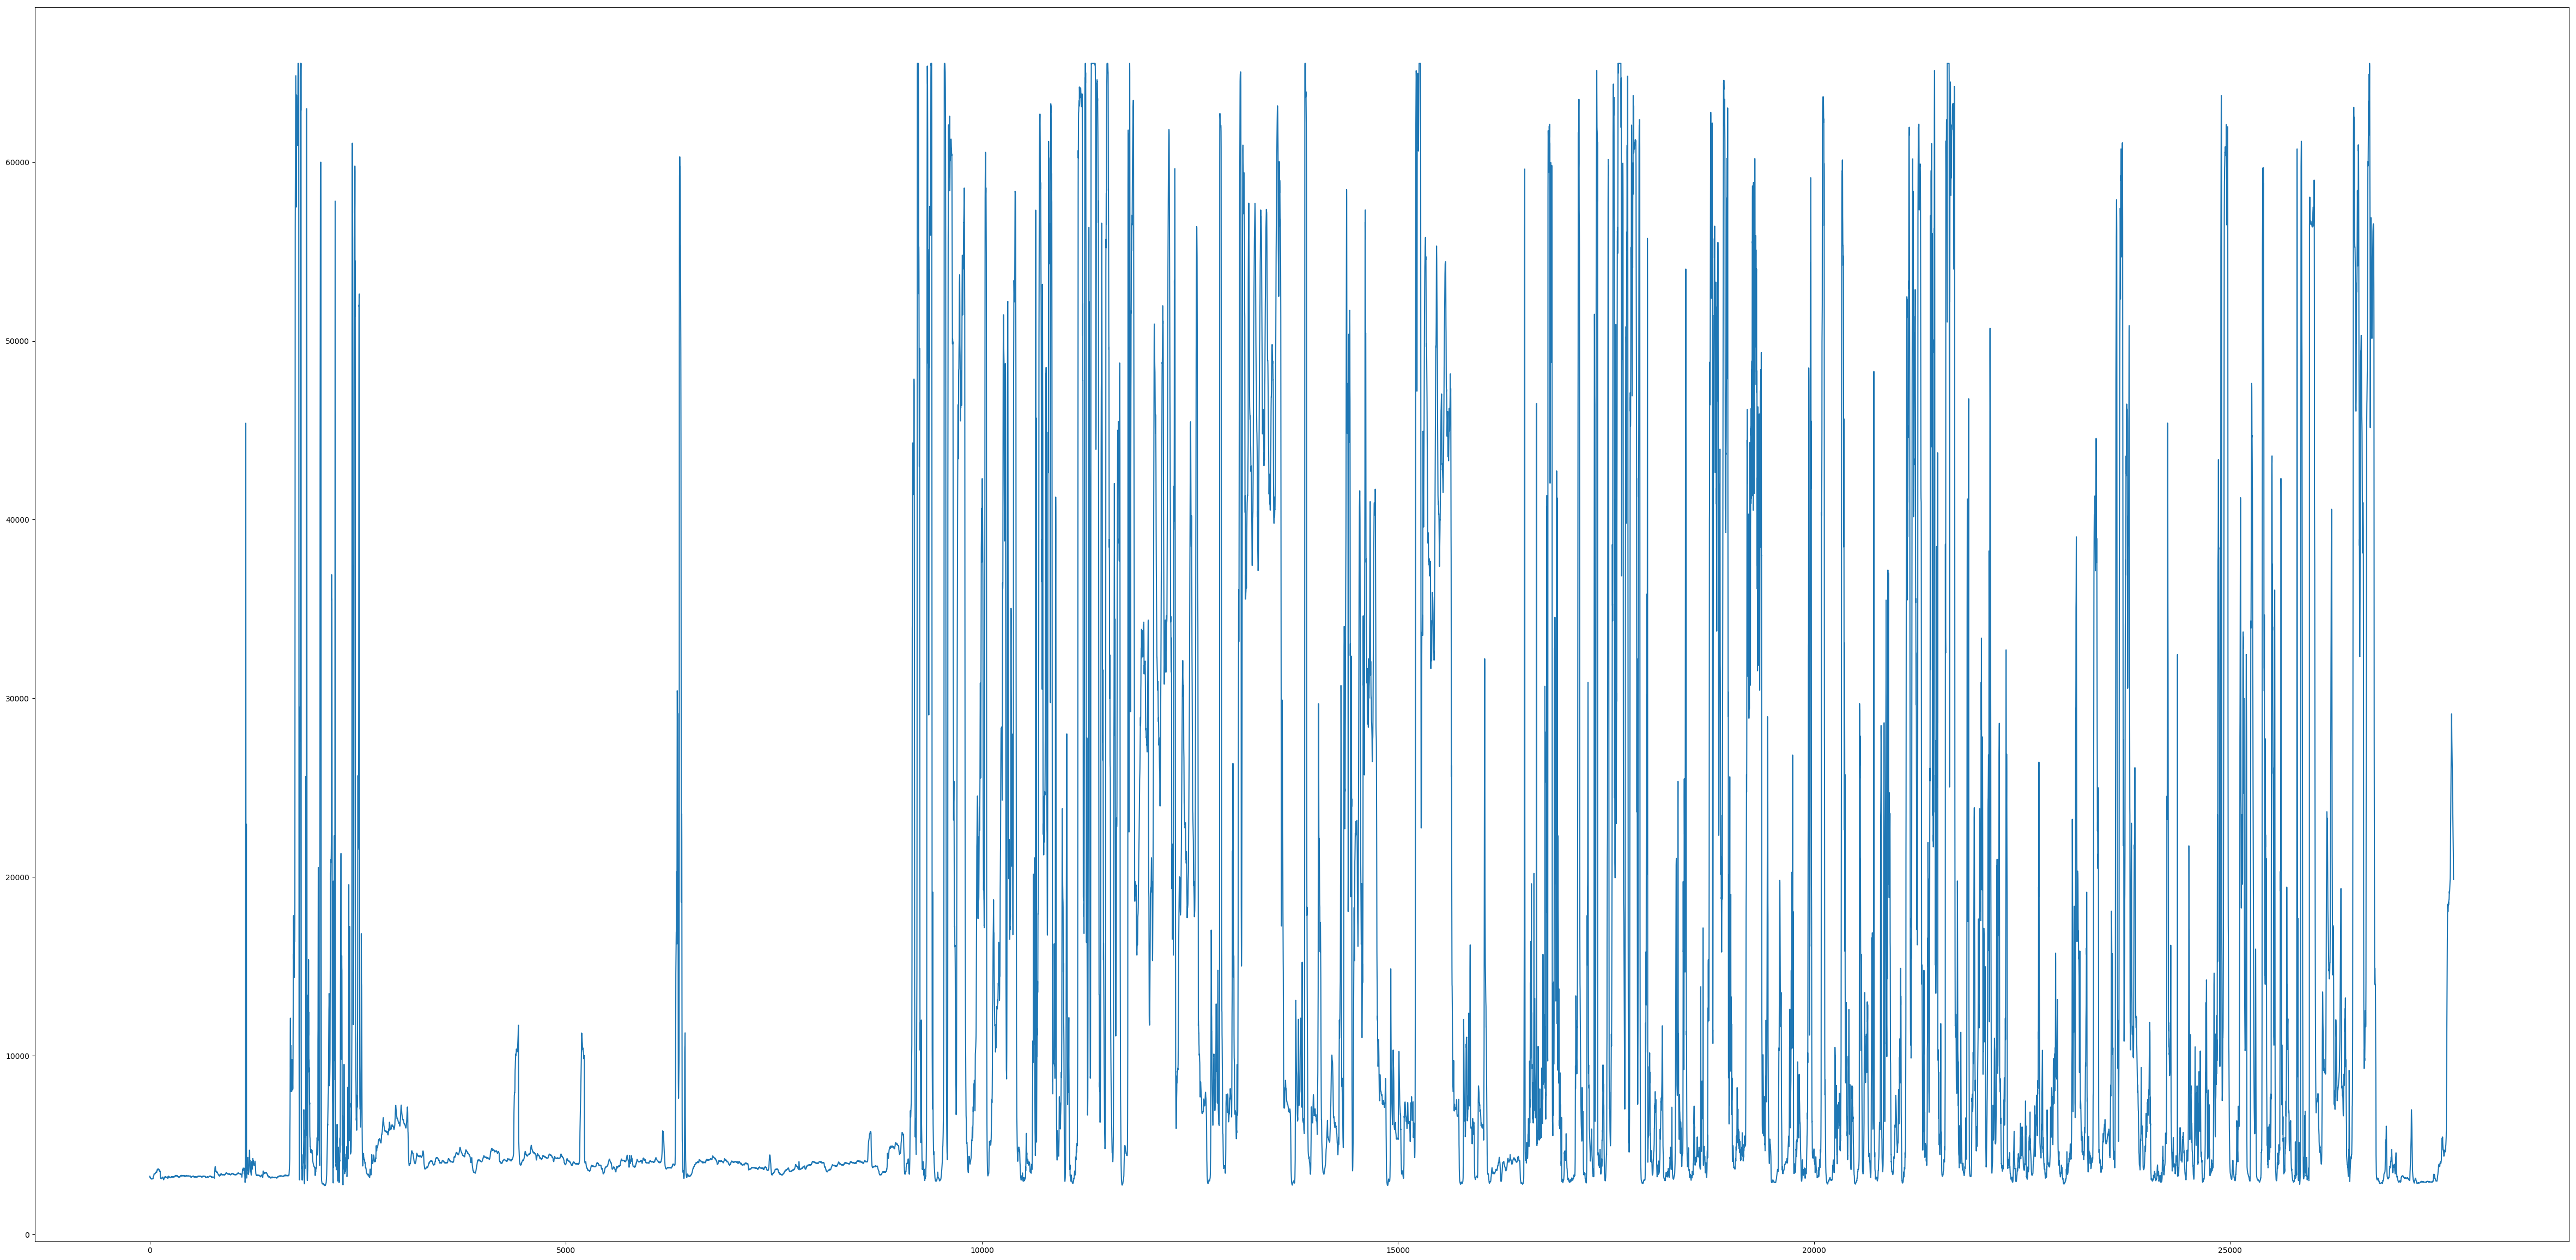

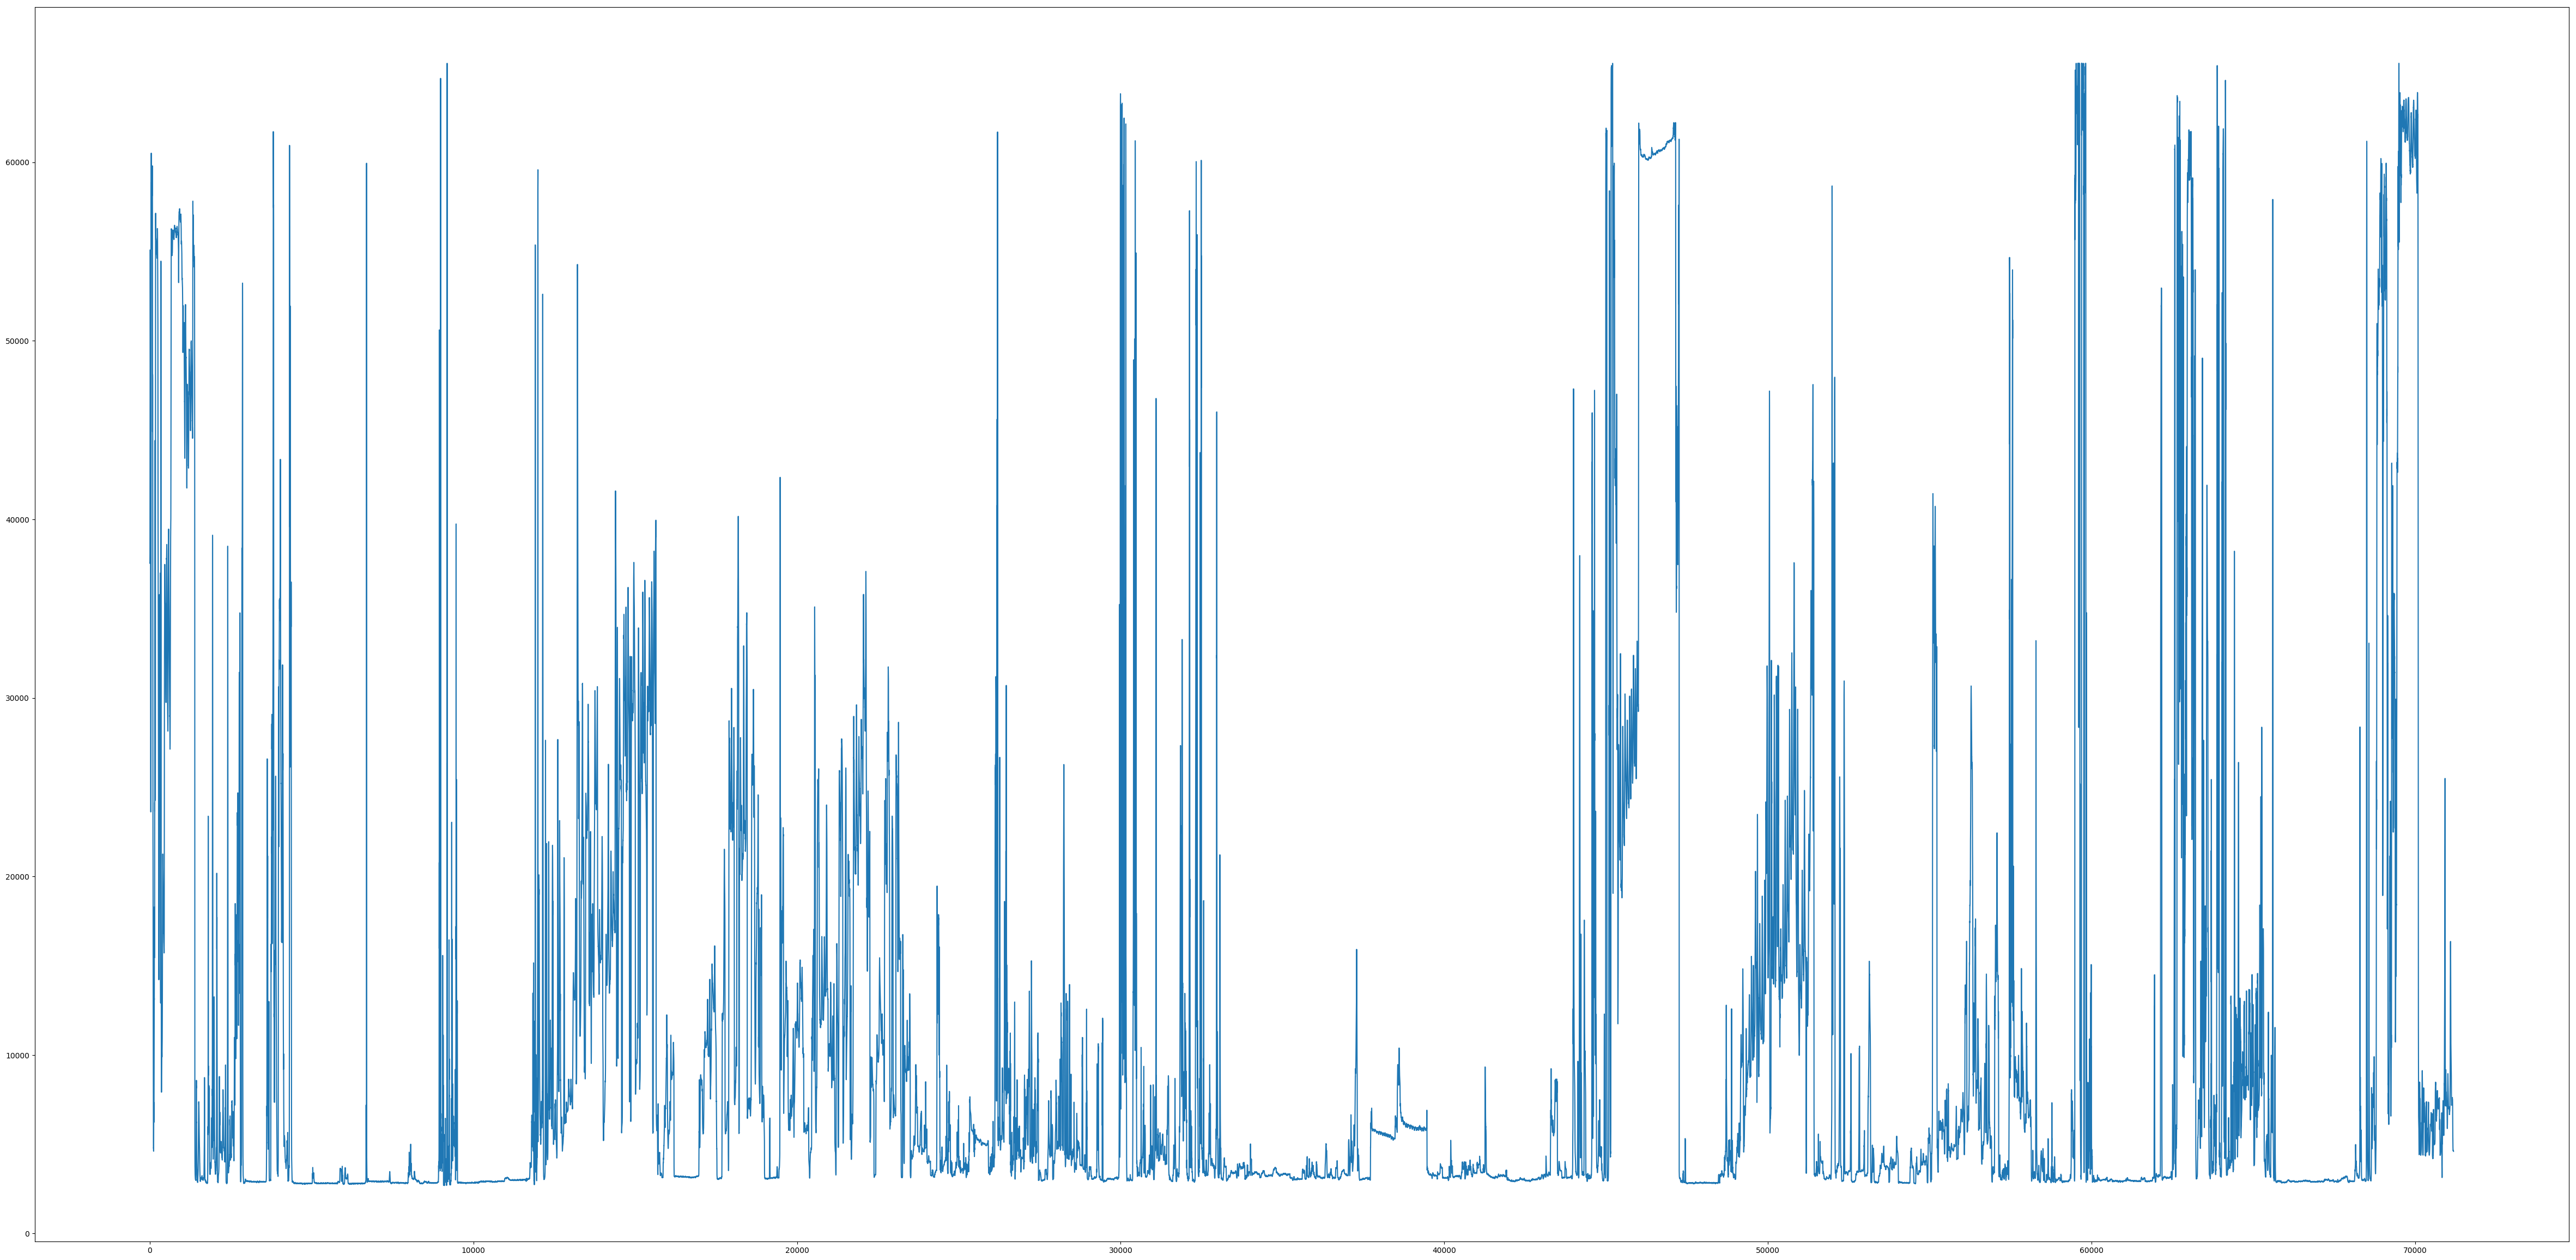

In [7]:
subj_list = ['203']

start_date_map = {  "203": date(2019,1,4),
                 }


# tasks can be 'check_necklace_worn_on_time', 'check_video_necklaceworn_overlap_time', 'check_camera_worn_on_time_part1', 'plot_necklace_day'
task = 'plot_necklace_day'


GT_FOLDER = 'CLEAN'

inclusion_file = 'inclusion.csv'

log_file = 'judge_worn_on_log3.txt'




for subj in subj_list:
    print('')
    print(subj)

    if task == 'check_necklace_worn_on_time':

        lprint(log_file,"Subject: {}".format(subj))

        start_date_obj = start_date_map[subj]
        total_worn_hour = 0 
        total_collected_hour = 0

        for n in range(14):
            lprint(log_file,"================")
            lprint(log_file,"Day: {}".format(n))

            resampled_path = "/Volumes/Seagate/Periodic/wild/" + subj + "/resampled_day_{}.p".format(n)

            if os.path.isfile(resampled_path):
                lprint(log_file,"Skipping resampling")
                df = pickle.load(open(resampled_path, "rb"))
                len_coll = len(df)
                len_worn = worn_on_points(df)

                lprint(log_file,'Worn hour: ', len_worn/20/60/60)
                total_worn_hour += len_worn/20/60/60
                lprint(log_file,'Collected hour: ', len_coll/20/60/60)
                total_collected_hour += len_coll/20/60/60


        lprint(log_file,'Total worn hours: ', total_worn_hour)
        lprint(log_file,'Total collected hours: ', total_collected_hour)
        lprint(log_file,' ')
        lprint(log_file,' ')



    elif task == 'check_video_necklaceworn_overlap_time':
        lprint(log_file,"Subject: {}".format(subj))

        directory = os.path.join(GT_FOLDER, subj, 'label')
        inclusion = pd.read_csv(os.path.join(directory, inclusion_file))

        start_date_obj = start_date_map[subj]
        overlap_hour = 0 

        for n in range(14):
            lprint(log_file,"================")
            lprint(log_file,"Day: {}".format(n))

            resampled_path = "/Volumes/Seagate/Periodic/wild/" + subj + "/resampled_day_{}.p".format(n)


            if os.path.isfile(resampled_path):
                lprint(log_file,"Skipping resampling")
                df = pickle.load(open(resampled_path, "rb"))


                for i in range(inclusion.shape[0]):
                    start = human_to_epoch(inclusion['start'].iloc[i])
                    end = human_to_epoch(inclusion['end'].iloc[i])
                    start_dt = datetime.datetime.fromtimestamp(start // 1000)
                    end_dt = datetime.datetime.fromtimestamp(end // 1000)
                    start_dt = TIMEZONE.localize(start_dt)
                    end_dt = TIMEZONE.localize(end_dt)

                    sel_df = df[(df.index >= start_dt) & (df.index <= end_dt)]


                    len_worn = worn_on_points(sel_df)

                    print(len(sel_df) - len_worn)

                    # day_hour += len_worn/20/60/60
                    overlap_hour += len_worn/20/60/60

            # lprint(log_file,'day_hour: ', day_hour)

        lprint(log_file,'overlap_hour: ', overlap_hour)
        lprint(log_file,' ')
        lprint(log_file,' ')




    elif task == 'check_camera_worn_on_time_part1':
        lprint(log_file,"Subject: {}".format(subj))

        directory = os.path.join(GT_FOLDER, subj, 'label')
        inclusion = pd.read_csv(os.path.join(directory, inclusion_file))

        for i in range(inclusion.shape[0]):
            start = human_to_epoch(inclusion['start'].iloc[i])
            end = human_to_epoch(inclusion['end'].iloc[i])
            # print(start)
            start_dt = datetime.datetime.fromtimestamp(start // 1000)
            # print(start_dt)
            end_dt = datetime.datetime.fromtimestamp(end // 1000)
            start_dt = TIMEZONE.localize(start_dt)
            end_dt = TIMEZONE.localize(end_dt)
            if i == 0:
                total_camera_worn_time = end_dt - start_dt
            else:
                total_camera_worn_time += (end_dt - start_dt)

        print(total_camera_worn_time)
        print(total_camera_worn_time.total_seconds()/3600.0)




    elif task == 'plot_necklace_day':
#         for n in range(3):
        if 1:
            lprint(log_file,"================")
            lprint(log_file,"Day: {}".format(n))
            path = "/Users/shibozhang/Documents/SenseWhy/Data/wild/CLEAN/203/NECKLACE/01-14-19_17.csv"

            if os.path.isfile(path):
                df = pd.read_csv(path)
                print(len(df))
                
                fig = plt.figure(num=None, figsize=(60, 30), dpi=100, facecolor='w', edgecolor='k')
                ax = fig.add_subplot(1,1,1)
                df['proximity'].plot()
                
                
            path = "/Users/shibozhang/Documents/SenseWhy/Data/wild/CLEAN/203/NECKLACE/01-14-19_23.csv"

            if os.path.isfile(path):
                df = pd.read_csv(path)
                print(len(df))
                
                fig = plt.figure(num=None, figsize=(60, 30), dpi=100, facecolor='w', edgecolor='k')
                ax = fig.add_subplot(1,1,1)
                df['proximity'].plot()